### 헥사스탯 돌깎기 계산기 사용법

1. 바로 아래 블럭의 변수들을 조정
2. '모두 실행' 버튼 클릭
3. 끝

In [22]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from collections import defaultdict

INF = 1 << 64

def reinforce(table, x, num_reinforcements, do_compress=True):
    init = table.create_vector(x)
    result = init @ np.linalg.matrix_power(
        table.get_matrix(),
        num_reinforcements
    )
    if do_compress:
        return table.compress_state_dict(table.vector_to_state_dict(result), [0])
    else:
        return result


def steady_state_distribution(M):
    pi = np.linalg.matrix_power(M, INF)
    return pi


def matrix_semi_inf_geometric_series(M):
    I = np.eye(M.shape[0])

    Q = steady_state_distribution(M)
    Z = M - Q

    inv_matrix = np.linalg.inv(I - Z)
    
    return inv_matrix 


def matrix_power_series(M, n):
    I = np.eye(M.shape[0])

    Q = steady_state_distribution(M)
    Z = M - Q

    Z_powered = np.linalg.matrix_power(Z, n+1)
    inv_matrix = np.linalg.inv(I - Z)
    
    return (I - Z_powered) @ inv_matrix + n*Q
    

class MarkovMatrix:
    def __init__(self):
        self.transitions = {}
        self.states = []
        self.state_index = {}
        self.compiled_matrix = None

    def add_transition(self, from_state, to_state, prob):
        if prob == 0:
            del self.transitions[(from_state, to_state)]
        else:
            self.transitions[(from_state, to_state)] = prob

    def clear_transition(self, from_state):
        fsstate_to_remove = []
        for fsstate in self.transitions.keys():
            fstate, to_state = fsstate
            if fstate == from_state:
                fsstate_to_remove.append(fsstate)

        for fsstate in fsstate_to_remove:
            del self.transitions[fsstate]

    def compile(self):
        # Create a unique list of all states
        states = set()
        for fsstate in self.transitions.keys():
            from_state, to_state = fsstate
            states.add(from_state)
            states.add(to_state)

        self.states = list(states)
        # Create a mapping from state to index
        self.state_index = {state: i for i, state in enumerate(self.states)}

        # Initialize the transition matrix
        size = len(self.states)
        self.compiled_matrix = np.zeros((size, size))

        # Fill the transition matrix with probabilities
        for fsstate, prob in self.transitions.items():
            from_state, to_state = fsstate

            from_index = self.state_index[from_state]
            to_index = self.state_index[to_state]

            self.compiled_matrix[from_index][to_index] = prob


    def get_matrix(self):
        if self.compiled_matrix is None:
            raise ValueError("The matrix has not been compiled. Call compile() first.")
        return self.compiled_matrix

    def get_states(self):
        return self.states

    def get_state_index(self):
        return self.state_index

    def create_vector(self, initial_states):
        """
        initial_states can be a single state (str or tuple) or a dictionary of states with their assigned probabilities.
        """
        vector = np.zeros(len(self.states))
        
        if isinstance(initial_states, (str, tuple)):
            if initial_states not in self.state_index:
                raise ValueError(f"State '{initial_states}' not found in state index.")
            vector[self.state_index[initial_states]] = 1.0
        elif isinstance(initial_states, dict):
            for state, prob in initial_states.items():
                if state not in self.state_index:
                    raise ValueError(f"State '{state}' not found in state index.")
                vector[self.state_index[state]] = prob
        else:
            raise ValueError("initial_states should be either a single state (str or tuple) or a dictionary of states with probabilities.")
        
        return vector

    def vector_to_state_dict(self, vector):
        """
        Converts a probability vector back to a dictionary of states with their probabilities.
        """
        if len(vector) != len(self.states):
            raise ValueError("The length of the vector does not match the number of states.")
        state_probabilities = {self.states[i]: vector[i] for i in range(len(self.states))}
        return state_probabilities
    
    def compress_state_dict(self, state_dict, indices):
        """
        Compresses the state dictionary based on the specified indices.
        """
        compressed = defaultdict(float)
        for state, value in state_dict.items():
            if isinstance(state, tuple):
                compressed_key = tuple(state[i] for i in indices)
            else:
                compressed_key = (state,)
            compressed[compressed_key] += value
        return dict(compressed)



class MarkovMatrix:
    def __init__(self):
        self.transitions = {}
        self.states = []
        self.state_index = {}
        self.compiled_matrix = None

    def add_transition(self, from_state, to_state, prob):
        if prob == 0:
            del self.transitions[(from_state, to_state)]
        else:
            self.transitions[(from_state, to_state)] = prob

    def clear_transition(self, from_state):
        fsstate_to_remove = []
        for fsstate in self.transitions.keys():
            fstate, to_state = fsstate
            if fstate == from_state:
                fsstate_to_remove.append(fsstate)

        for fsstate in fsstate_to_remove:
            del self.transitions[fsstate]

    def compile(self):
        # Create a unique list of all states
        states = set()
        for fsstate in self.transitions.keys():
            from_state, to_state = fsstate
            states.add(from_state)
            states.add(to_state)

        self.states = list(states)
        # Create a mapping from state to index
        self.state_index = {state: i for i, state in enumerate(self.states)}

        # Initialize the transition matrix
        size = len(self.states)
        self.compiled_matrix = np.zeros((size, size))

        # Fill the transition matrix with probabilities
        for fsstate, prob in self.transitions.items():
            from_state, to_state = fsstate

            from_index = self.state_index[from_state]
            to_index = self.state_index[to_state]

            self.compiled_matrix[from_index][to_index] = prob


    def get_matrix(self):
        if self.compiled_matrix is None:
            raise ValueError("The matrix has not been compiled. Call compile() first.")
        return self.compiled_matrix

    def get_states(self):
        return self.states

    def get_state_index(self):
        return self.state_index

    def create_vector(self, initial_states):
        """
        initial_states can be a single state (str or tuple) or a dictionary of states with their assigned probabilities.
        """
        vector = np.zeros(len(self.states))
        
        if isinstance(initial_states, (str, tuple)):
            if initial_states not in self.state_index:
                raise ValueError(f"State '{initial_states}' not found in state index.")
            vector[self.state_index[initial_states]] = 1.0
        elif isinstance(initial_states, dict):
            for state, prob in initial_states.items():
                if state not in self.state_index:
                    raise ValueError(f"State '{state}' not found in state index.")
                vector[self.state_index[state]] = prob
        else:
            raise ValueError("initial_states should be either a single state (str or tuple) or a dictionary of states with probabilities.")
        
        return vector

    def vector_to_state_dict(self, vector):
        """
        Converts a probability vector back to a dictionary of states with their probabilities.
        """
        if len(vector) != len(self.states):
            raise ValueError("The length of the vector does not match the number of states.")
        state_probabilities = {self.states[i]: vector[i] for i in range(len(self.states))}
        return state_probabilities

    def compress_state_dict(self, state_dict, indices):
        """
        Compresses the state dictionary based on the specified indices.
        """
        compressed = defaultdict(float)
        for state, value in state_dict.items():
            if isinstance(state, tuple):
                compressed_key = tuple(state[i] for i in indices)
            else:
                compressed_key = (state,)
            compressed[compressed_key] += value
        return dict(compressed)


MAX_LEVEL = 10  # 총 단계 수
MAX_ATTEMPTS = 20  # 최대 시도 횟수


def find_strategy(goal_level, high_value_preference, frag_price, reset_cost, is_sunday=False):
    hsm = HexaStrategyModel(goal_level, hexa_frag_cost, hexa_prob[is_sunday], frag_price, reset_cost, MAX_LEVEL, MAX_ATTEMPTS, high_value_preference=high_value_preference)
    
    last_one_indices = []
    for col in range(hsm.should_stop.shape[1]):
        rows_with_ones = np.where(hsm.should_stop[:, col] == 1)[0]
        if rows_with_ones.size > 0:
            last_one_indices.append(rows_with_ones[-1])
        else:
            last_one_indices.append(-1)  # 1이 없는 경우 -1로 표시

    t = '이상' if high_value_preference else '이하'
    print(f'[메인스탯 {goal_level} {t} 목표 시 강화 전략]')
    print()
    prev = -1
    for i in range(10, MAX_ATTEMPTS+1):
        if last_one_indices[i] != prev:
            print(f'{i}회 강화 후 메인스탯 {last_one_indices[i]} 이하면 초기화')
        prev = last_one_indices[i]



def hexa_myulmangjeon(goal_level, high_value_preference, frag_price, reset_cost, is_sunday=False):
    hsm = HexaStrategyModel(goal_level, hexa_frag_cost, hexa_prob[is_sunday], frag_price, reset_cost, MAX_LEVEL, MAX_ATTEMPTS, high_value_preference=high_value_preference)

    num_reinforcements = 1 << 64
    x = {(0, 0): 1} # main-level, attempts

    ######## Apply Strategy ########

    table = hexa_table[is_sunday]
    strategy_table = copy.deepcopy(table)


    for m in range(MAX_LEVEL+1):
        for t in range(MAX_ATTEMPTS+1):
            if hsm.should_stop[m][t]:
                strategy_table.clear_transition((m, t))
                strategy_table.add_transition((m, t), (0, 0), 1.0)


    if high_value_preference:
        for level in range(goal_level, MAX_LEVEL+1):
            strategy_table.clear_transition((level, MAX_ATTEMPTS))
            strategy_table.add_transition((level, MAX_ATTEMPTS), (level, MAX_ATTEMPTS), 1.0)
    else:
        for level in range(0, goal_level+1):
            strategy_table.clear_transition((level, MAX_ATTEMPTS))
            strategy_table.add_transition((level, MAX_ATTEMPTS), (level, MAX_ATTEMPTS), 1.0)

    strategy_table.compile()

    ######## Do Reinforce ########

    result = reinforce(strategy_table, x, num_reinforcements)

    result_vector = np.zeros(MAX_LEVEL+1)
    for i in range(MAX_LEVEL+1):
        result_vector[i] = result[(i,)]


    ######## Log & Visualize ########

    fig, ax = plt.subplots(figsize=(10, 3))
    bars = ax.bar(range(len(result_vector)), result_vector)

    # 각 막대 위에 값 표시
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, f'{round(100*yval, 2)}%', ha='center', va='bottom')

    # y축 범위 설정
    ax.set_ylim(0, 1)
    plt.show()


    def cost_branch(state, hsm, only_frag=False):
        i, j = state
        if hsm.should_stop[i][j]:
            return reset_cost if not only_frag else 0
        elif j == 20:
            return 0
        else:
            return hexa_frag_cost[i] * hex_frag_multiplier * frag_price if not only_frag else hexa_frag_cost[i] * hex_frag_multiplier


    strategy_cost = strategy_table.create_vector({
        (i, j) : cost_branch((i, j), hsm) for i, j in strategy_table.states
    })

    strategy_frag_cost = strategy_table.create_vector({
        (i, j) : cost_branch((i, j), hsm, True) for i, j in strategy_table.states
    })

    xvector = strategy_table.create_vector(x)
    migs = matrix_semi_inf_geometric_series(strategy_table.get_matrix())

    expected_cost = xvector @ migs @ strategy_cost.T
    expected_frag_cost = xvector @ migs @ strategy_frag_cost.T

    for i, p in enumerate(result_vector):
        if p > 0:
            print(f'메인 {i:3d}레벨 확률: {p*100:2.2f}%')

    print()

    print(f"평균 총 메소 소모량\t: {round(expected_cost, 2)} 억 메소")
    print(f"평균 조각 소모량\t\t: {round(expected_frag_cost, 2)} 개")


def hexa_try(goal_level, num_frags, high_value_preference, frag_price, reset_cost, is_sunday=False):
    hsm = HexaStrategyModel(goal_level, hexa_frag_cost, hexa_prob[is_sunday], frag_price, reset_cost, MAX_LEVEL, MAX_ATTEMPTS, high_value_preference=high_value_preference)

    x = {(0, 0, 0): 1} # main-level, attempts, spent-frags

    ######## Apply Strategy ########

    table = hexa_table_frag[is_sunday]
    strategy_table = copy.deepcopy(table)

    init_states = []
    for fsstate, prob in strategy_table.transitions.items():
        from_state, to_state = fsstate
        m, t, f = to_state
        if hsm.should_stop[m][t] and f == 0:
            init_states.append((from_state, to_state, prob))

    for from_state, to_state, prob in init_states:
        del strategy_table.transitions[(from_state, to_state)]
        prev_prob = strategy_table.transitions.get((from_state, (0, 0, 0)), 0)
        strategy_table.add_transition(from_state, (0, 0, 0), prev_prob + prob)


    if high_value_preference:
        for level in range(goal_level, MAX_LEVEL+1):
            strategy_table.clear_transition((level, MAX_ATTEMPTS, 0))
            strategy_table.add_transition((level, MAX_ATTEMPTS, 0), (level, MAX_ATTEMPTS, 0), 1.0)   
    else:
        for level in range(0, goal_level+1):
            strategy_table.clear_transition((level, MAX_ATTEMPTS, 0))
            strategy_table.add_transition((level, MAX_ATTEMPTS, 0), (level, MAX_ATTEMPTS, 0), 1.0)

    strategy_table.compile()

    result_vector = np.zeros(MAX_LEVEL+1)

    ######## Do Reinforce ########
    if high_value_preference:
        result = reinforce(strategy_table, x, num_frags // hex_frag_multiplier)

        for i in range(MAX_LEVEL+1):
            result_vector[i] = result[(i,)]

    else:
        result = reinforce(strategy_table, x, num_frags // hex_frag_multiplier, False)
        result = strategy_table.compress_state_dict(strategy_table.vector_to_state_dict(result), [0, 1])
        for i in range(MAX_LEVEL+1):
            result_vector[i] = result.get((i,MAX_ATTEMPTS), 0)

    ######## Log & Visualize ########

    fig, ax = plt.subplots(figsize=(10, 3))
    bars = ax.bar(range(len(result_vector)), result_vector)

    # 각 막대 위에 값 표시
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, f'{round(100*yval, 2)}%', ha='center', va='bottom')

    # y축 범위 설정
    ax.set_ylim(0, 1)
    plt.show()

    for i, p in enumerate(result_vector):
        if p > 0:
            print(f'메인 {i:3d}레벨 확률: {p*100:2.2f}%')

    print()

    if high_value_preference:
        print('성공률:', str(round(100*np.sum(result_vector[goal_level:]), 2)) + '%')
    else:
        print('성공률:', str(round(100*np.sum(result_vector[:goal_level+1]), 2)) + '%')


hexa_prob = [
    np.array([0.35, 0.35, 0.35, 0.2, 0.2, 0.2, 0.2, 0.15, 0.1, 0.05, 0], dtype=np.float32),
    np.array([
        0.35, 0.35, 0.35, 0.2, 0.2, 
        0.2 *1.2, 0.2 *1.2, 0.15 *1.2, 0.1 *1.2, 0.05 *1.2, 
        0
    ], dtype=np.float32)
]

hex_frag_multiplier = 10
hexa_frag_cost = np.array([1, 1, 1, 2, 2, 2, 2, 3, 3, 5, 5])


def _build_hexa_table(prob):
    markov = MarkovMatrix()
    for i in range(11):
        for j in range(i, 20):
            if i+1 <= 10:
                markov.add_transition((i, j), (i+1, j+1), prob[i])
            markov.add_transition((i, j), (i, j+1), 1-prob[i])

    markov.compile()
    return markov

def _build_hexa_table_frag(prob, _hexa_frag_cost):
    markov = MarkovMatrix()
    for i in range(11):
        for j in range(i, 20):
            for k in range(_hexa_frag_cost[i]-1):
                markov.add_transition((i, j, k), (i, j, k+1), 1)

            if i+1 <= 10:
                markov.add_transition((i, j, _hexa_frag_cost[i]-1), (i+1, j+1, 0), prob[i])
            markov.add_transition((i, j, _hexa_frag_cost[i]-1), (i, j+1, 0), 1-prob[i])
    
    markov.compile()
    return markov

hexa_table = [
    _build_hexa_table(hexa_prob[0]),
    _build_hexa_table(hexa_prob[1])
]

hexa_table_frag = [
    _build_hexa_table_frag(hexa_prob[0], hexa_frag_cost),
    _build_hexa_table_frag(hexa_prob[1], hexa_frag_cost)
]


class HexaStrategyModel:
    def __init__(self, goal_level, frag_cost, hexa_prob, frag_meso, init_meso, max_level=10, max_attempts=20, iteration=100, high_value_preference=True):
        def solve_bs(x):
            cost = np.zeros((max_level + 1, max_attempts + 1), dtype=np.float32)
            go_or_stop = np.zeros_like(cost, dtype=np.int32)

            stop_cost = init_meso + x

            # 최대 수치에 도달한 경우
            for t in range(max_level, max_attempts+1):
                if high_value_preference:
                    cost[max_level][t] = frag_cost[max_level] * frag_meso * (max_attempts - t)
                else:
                    cost[max_level][t] = stop_cost
                    go_or_stop[max_level][t] = 1

            # 최대 강화 횟수에 도달한 경우
            for m in range(0, max_level+1):
                if (high_value_preference and m < goal_level) or (not high_value_preference and m > goal_level):
                    cost[m][max_attempts] = stop_cost
                    go_or_stop[m][max_attempts] = 1
                
            # 초기화 or 강화 선택
            for m in range(max_level-1, 0-1, -1):
                for t in range(max_attempts-1, m-1, -1):
                    go_cost = frag_cost[m] * frag_meso + hexa_prob[m] * cost[m+1][t+1] + (1-hexa_prob[m]) * cost[m][t+1]

                    if t < 10 or (high_value_preference and m >= goal_level):
                        cost[m][t] = go_cost
                        
                    elif not high_value_preference and m > goal_level:
                        cost[m][t] = stop_cost
                        go_or_stop[m][t] = 1

                    else:
                        if go_cost <= stop_cost:
                            cost[m][t] = go_cost
                        else:
                            cost[m][t] = stop_cost
                            go_or_stop[m][t] = 1
                    
            return cost, go_or_stop

        # 이분탐색을 통해 true value 탐색
        s = 1
        e = 1000000
        ground_x = -1

        expected_cost, go_or_stop = None, None

        for i in range(iteration):
            m = (s + e) / 2
            expected_cost, go_or_stop = solve_bs(m)
            ground_x = expected_cost[0][0]

            if ground_x > m:
                s = m
            else:
                e = m

        self.expected_cost = expected_cost
        self.should_stop = go_or_stop

In [23]:
goal_level = 8                 # 메인 스탯 목표 레벨
high_value_preference = True   # goal_level 이상의 레벨을 원할 시 True, 이하를 원할 시 False

frag_price = 0.07               # 솔 에르다 조각 시세 (단위: 억 메소)
reset_cost = 0.1                # 코어 초기화 비용 (단위: 억 메소) 

is_sunday = False               # 썬데이 메이플 적용 여부
num_frags = 3000               # 준비한 조각 개수

### ▼&nbsp;&nbsp;헥사스탯 최적 강화 전략

In [24]:
find_strategy(goal_level, high_value_preference, frag_price, reset_cost, is_sunday)

[메인스탯 8 이상 목표 시 강화 전략]

10회 강화 후 메인스탯 3 이하면 초기화
14회 강화 후 메인스탯 4 이하면 초기화
17회 강화 후 메인스탯 5 이하면 초기화
19회 강화 후 메인스탯 6 이하면 초기화
20회 강화 후 메인스탯 7 이하면 초기화


&nbsp;
### ▼&nbsp;&nbsp;준비된 조각만큼 강화 시 도달 레벨 분포

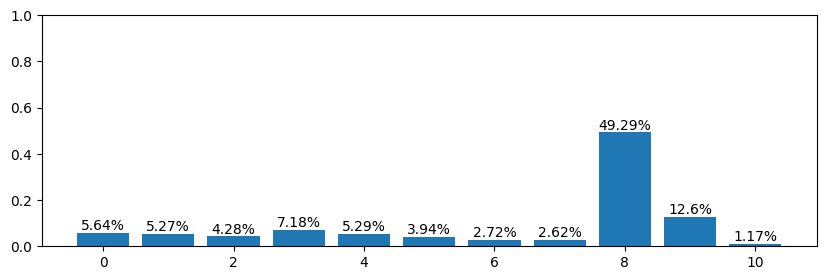

메인   0레벨 확률: 5.64%
메인   1레벨 확률: 5.27%
메인   2레벨 확률: 4.28%
메인   3레벨 확률: 7.18%
메인   4레벨 확률: 5.29%
메인   5레벨 확률: 3.94%
메인   6레벨 확률: 2.72%
메인   7레벨 확률: 2.62%
메인   8레벨 확률: 49.29%
메인   9레벨 확률: 12.60%
메인  10레벨 확률: 1.17%

성공률: 63.06%


In [25]:
hexa_try(goal_level, num_frags, high_value_preference, frag_price, reset_cost, is_sunday)

### ▼&nbsp;&nbsp;무한 조각 멸망전 시 도달 레벨 분포 + 메소 / 조각 기대값

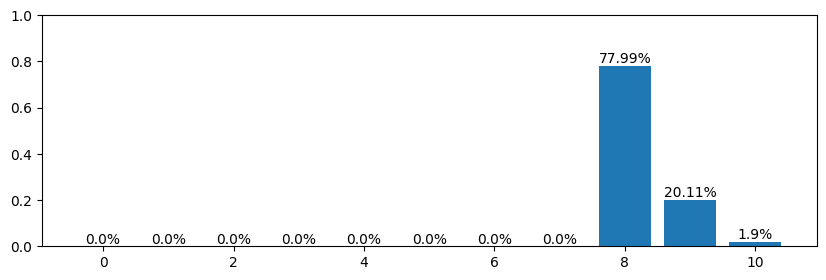

메인   8레벨 확률: 77.99%
메인   9레벨 확률: 20.11%
메인  10레벨 확률: 1.90%

평균 총 메소 소모량	: 218.85 억 메소
평균 조각 소모량		: 3103.77 개


In [26]:
hexa_myulmangjeon(goal_level, high_value_preference, frag_price, reset_cost, is_sunday)